In [7]:
import json
import pandas as pd
from datetime import datetime
import json
import re
import ast
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.multivariate.manova import MANOVA
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

In [8]:
# Load data
tweets = pd.read_parquet('X_t_tm_new.parquet')
tweets = tweets[[col for col in tweets.columns if not col.startswith("u.")]]
tweets.columns = tweets.columns.str.replace(r"^t\.", "", regex=True)
tweets = tweets.drop(columns=["hashtags", "urls", "user_mentions", "seniority_at_tweeting"])

label = pd.read_parquet('y_t_tm_new.parquet')
label = pd.DataFrame(label)
tweets['label'] = label
print(tweets.columns.to_list())

# Separate features and the target variable
topics = tweets[['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9']]
emotions = tweets[['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'neutral', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise']]
label = tweets['label']
week = tweets['week']



['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'neutral', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'week', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'label']


In [3]:
def bar_plot(data, y, title, x_axis, y_axis, file_name, rotation):
    x_bars = data.columns[1:]
    x_bars = [col.split('_')[-1] for col in x_bars]
    
    # Set up the positions for the bars
    bar_width = 0.2  # Width of each bar
    positions = np.arange(len(x_bars))  # Base positions for the bars
    
    # Set up the figure
    plt.figure(figsize=(16, 8))
        
    if y == "label":
        custom_labels = {0: 'Not Retweeted', 1: 'Retweeted'}
    elif y == "week":
        custom_labels = {1: 'Week 1', 2: 'Week 2', 3: 'Week 3', 4: 'Week 4'}


    # Plot each week's data with an offset for grouping
    for i, label in enumerate(data[y]):
        plt.bar(positions + i * bar_width, data.iloc[i, 1:], bar_width, label=custom_labels[label])

    
    plt.xlabel(x_axis, fontsize=14)
    plt.ylabel(y_axis, fontsize=14)
    plt.title(title, fontsize=18)
    plt.xticks(positions + bar_width * 1.5, x_bars, rotation=rotation, fontsize=14)  
    plt.legend(fontsize=14)

    plt.tight_layout()
    file_name = f'{file_name}.png'
    plt.savefig(file_name, dpi=300)
    plt.show()

In [6]:
def significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

In [4]:
# Emotions
df_emotions = tweets.drop(columns=["topic_1", "topic_2", "topic_3", "topic_4", "topic_5", "topic_6", "topic_7", "topic_8", "topic_9", "neutral"])

emotion_by_week= df_emotions.groupby("week").mean().reset_index()
emotion_by_week.columns = emotion_by_week.columns.str.replace(r"^t\.", "", regex=True)
pd.set_option('display.max_columns', None)
emotion_by_week = emotion_by_week.drop("label", axis=1)
print(emotion_by_week)

emotion_by_label= df_emotions.groupby("label").mean().reset_index()
emotion_by_label.columns = emotion_by_label.columns.str.replace(r"^t\.", "", regex=True)
pd.set_option('display.max_columns', None)
emotion_by_label = emotion_by_label.drop("week", axis=1)
print(emotion_by_label)

positive_emotions = ["admiration", "amusement", "approval", "caring", "desire", "excitement", 
                     "gratitude", "joy", "love", "optimism", "pride", "relief"]

negative_emotions = ["anger", "annoyance", "disappointment", "disapproval", "disgust", "embarrassment",
                     "fear", "grief", "nervousness", "remorse", "sadness"]

ambiguous_emotions = ["confusion", "curiosity", "realization", "surprise"]



   week  admiration  amusement     anger  annoyance  approval    caring  \
0     1    0.073407   0.027684  0.004883   0.023630  0.087891  0.006510   
1     2    0.060889   0.025901  0.005084   0.022940  0.087172  0.007228   
2     3    0.053313   0.024122  0.004377   0.021150  0.080123  0.007721   
3     4    0.047635   0.021375  0.004253   0.020989  0.078372  0.007530   

   confusion  curiosity    desire  disappointment  disapproval   disgust  \
0   0.038953   0.076410  0.008670        0.017071     0.027124  0.003199   
1   0.039712   0.082318  0.008941        0.016092     0.025896  0.003071   
2   0.040280   0.084344  0.007973        0.014104     0.024170  0.002930   
3   0.039330   0.080987  0.007833        0.013368     0.025313  0.003003   

   embarrassment  excitement      fear  gratitude     grief       joy  \
0       0.001658    0.022840  0.008952   0.013753  0.000517  0.017723   
1       0.001724    0.020176  0.008553   0.016202  0.000523  0.015255   
2       0.001577    0.01

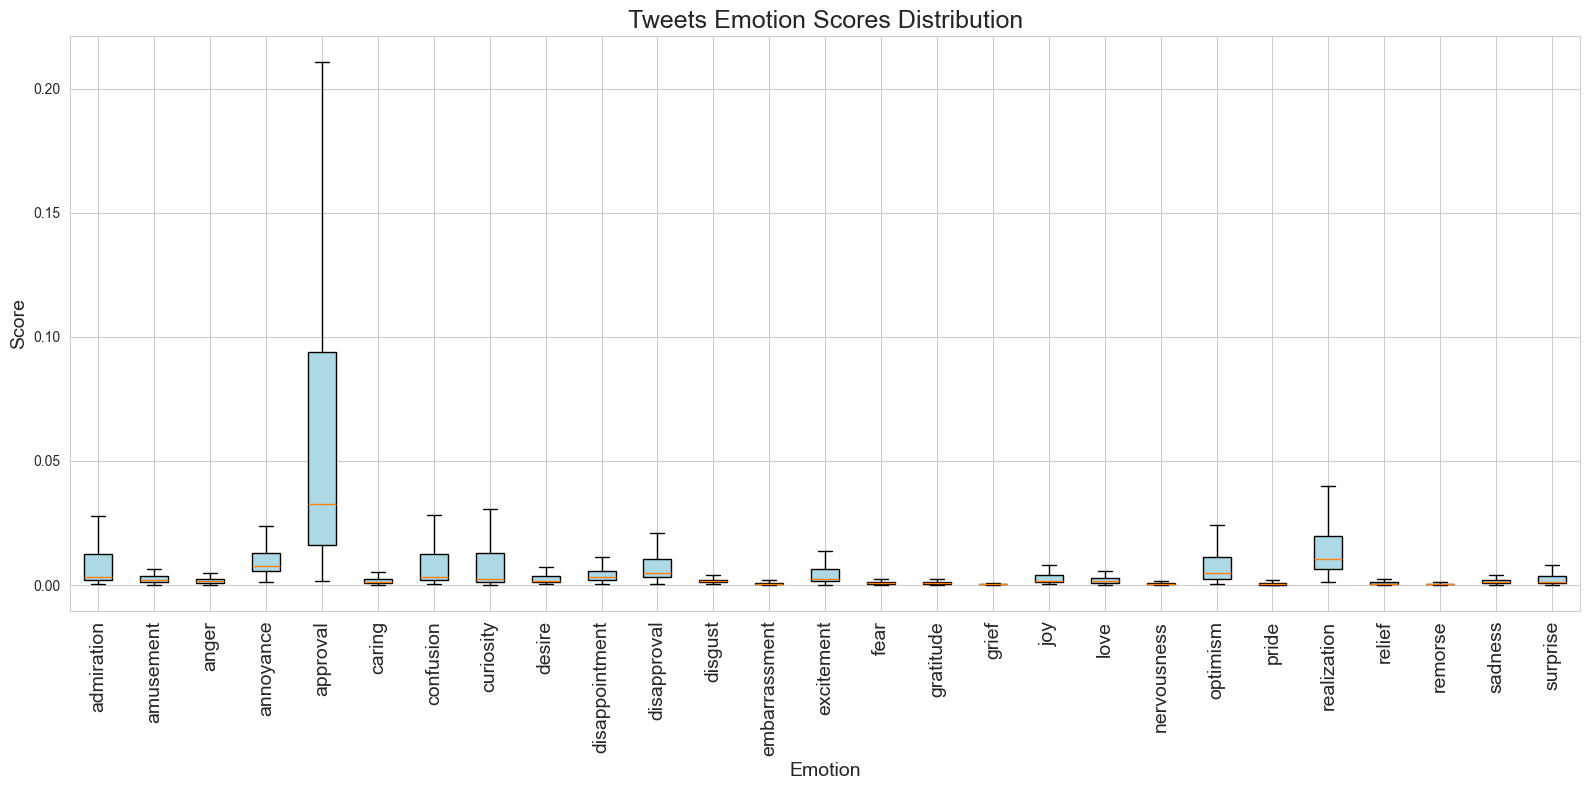

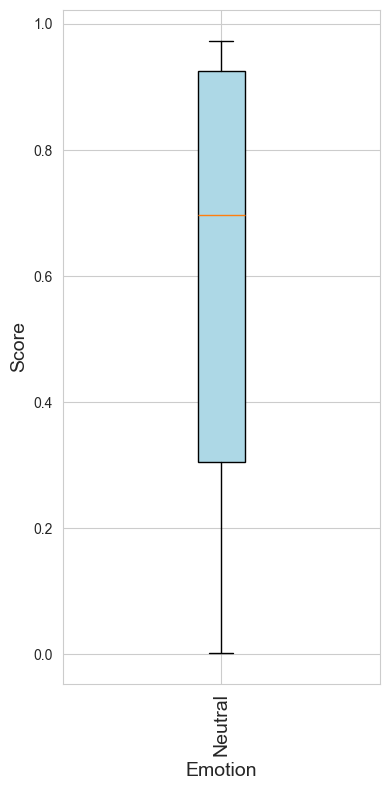

In [5]:
# Tweets Emotions Distribution

columns_to_drop = ['week', 'label']
emotions_dist = df_emotions.drop(columns=[col for col in columns_to_drop if col in df_emotions.columns])

fig, ax = plt.subplots(figsize=(16, 8))
bplot = ax.boxplot(
    [emotions_dist[col].dropna() for col in emotions_dist.columns],
    patch_artist=True, 
    showfliers=False   # Do not show outliers
)

for box in bplot['boxes']:
    box.set_facecolor('lightblue')  
    box.set_edgecolor('black')

ax.set_xlabel('Emotion', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Tweets Emotion Scores Distribution', fontsize=18)
ax.set_xticklabels(emotions_dist.columns, rotation=90, fontsize=14)

plt.tight_layout()
plt.savefig('Boxplot_EmotionScores.png', dpi=300)  
plt.show()


neutral = tweets['neutral']

fig, ax = plt.subplots(figsize=(4, 8))
bplot = ax.boxplot(
    neutral.dropna(),
    patch_artist=True,  
    showfliers=False    # Do not show outliers
)

for box in bplot['boxes']:
    box.set_facecolor('#ADD8E6')  
    box.set_edgecolor('black')


ax.set_xlabel('Emotion', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_xticklabels(['Neutral'], rotation=90, fontsize=14)

plt.tight_layout()
plt.savefig('neutralBoxPlot.png', dpi=300) 
plt.show()

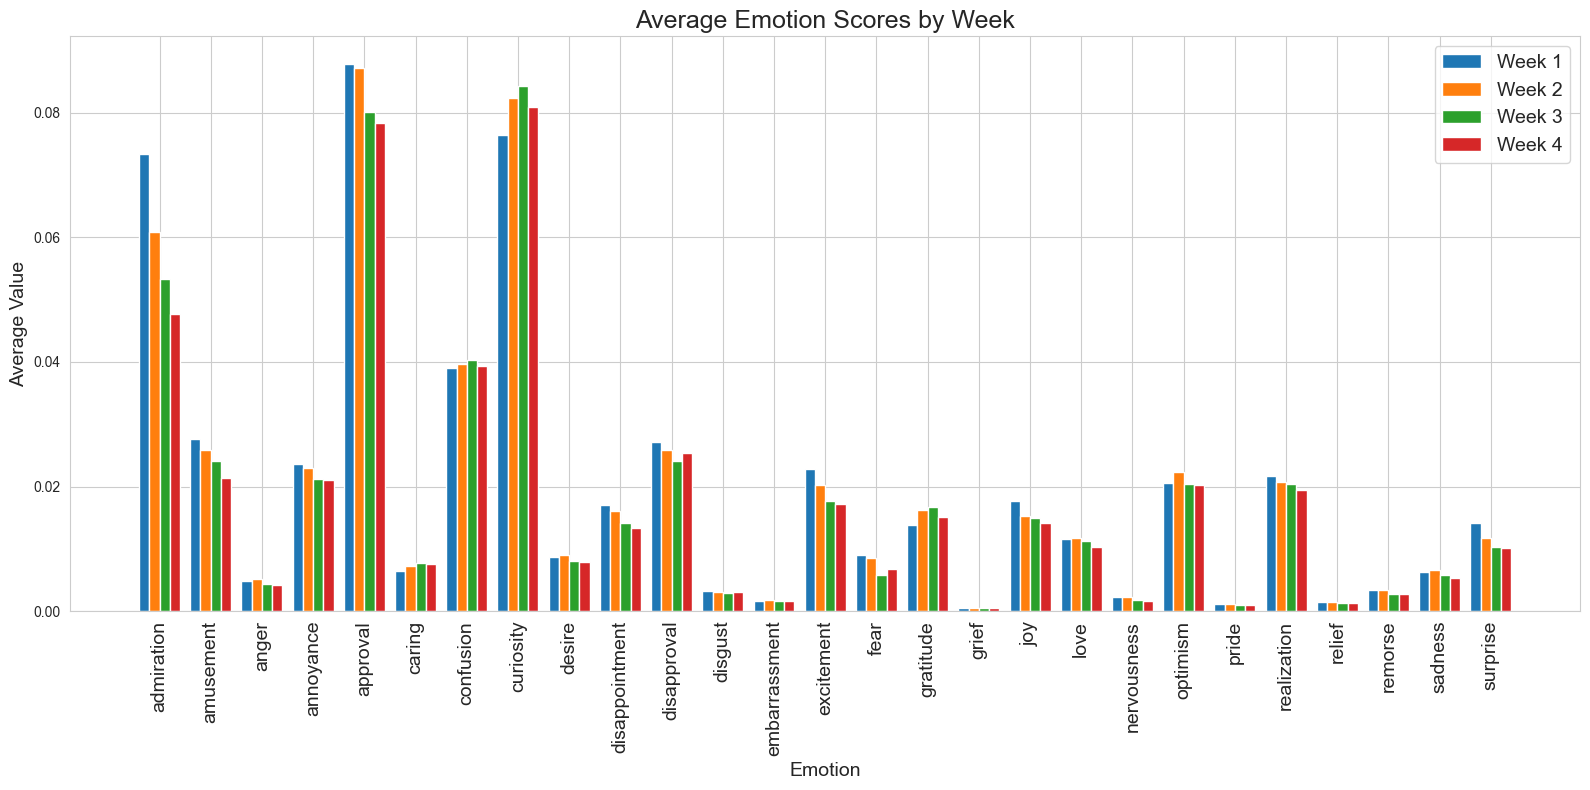

MANOVA Test - Emotions ~ Week
                      Multivariate linear model
                                                                      
----------------------------------------------------------------------
       Intercept         Value   Num DF    Den DF     F Value   Pr > F
----------------------------------------------------------------------
          Wilks' lambda  0.0255 28.0000 321032.0000 438959.8567 0.0000
         Pillai's trace  0.9745 28.0000 321032.0000 438959.8567 0.0000
 Hotelling-Lawley trace 38.2855 28.0000 321032.0000 438959.8567 0.0000
    Roy's greatest root 38.2855 28.0000 321032.0000 438959.8567 0.0000
----------------------------------------------------------------------
                                                                      
-----------------------------------------------------------------------
           week           Value    Num DF     Den DF    F Value  Pr > F
--------------------------------------------------------------------

In [9]:
# Emotions ~ week

bar_plot(emotion_by_week, "week", "Average Emotion Scores by Week", "Emotion", "Average Value", "EmotionByWeek", 90)

# MANOVA
print("MANOVA Test - Emotions ~ Week")
print(MANOVA.from_formula('admiration + amusement + anger + annoyance + approval + caring + confusion + curiosity + desire + disappointment + disapproval + disgust + embarrassment + excitement + fear + gratitude + grief + joy + love + nervousness + neutral + optimism + pride + realization + relief + remorse + sadness + surprise ~ week', data=tweets).mv_test())

# One-way ANOVA
print("One-way ANOVA - Emotions ~ Week")
print(f"{'Feature':<{20}} {'F-statistic':<{15}} {'p-value':<{15}} Significance")

for column in emotions.columns:   # Loop through each emotion feature and perform a one-way ANOVA
    week_1 = tweets[tweets['week'] == 1][column]
    week_2 = tweets[tweets['week'] == 2][column]
    week_3 = tweets[tweets['week'] == 3][column]
    week_4 = tweets[tweets['week'] == 4][column]
    
    # Perform one-way ANOVA
    f_stat, p_value = f_oneway(week_1, week_2, week_3, week_4)
    stars = significance_stars(p_value)
    print(f"{column:<{20}} {f_stat:<{15}.4f} {p_value:<{15}.4f} {stars}")

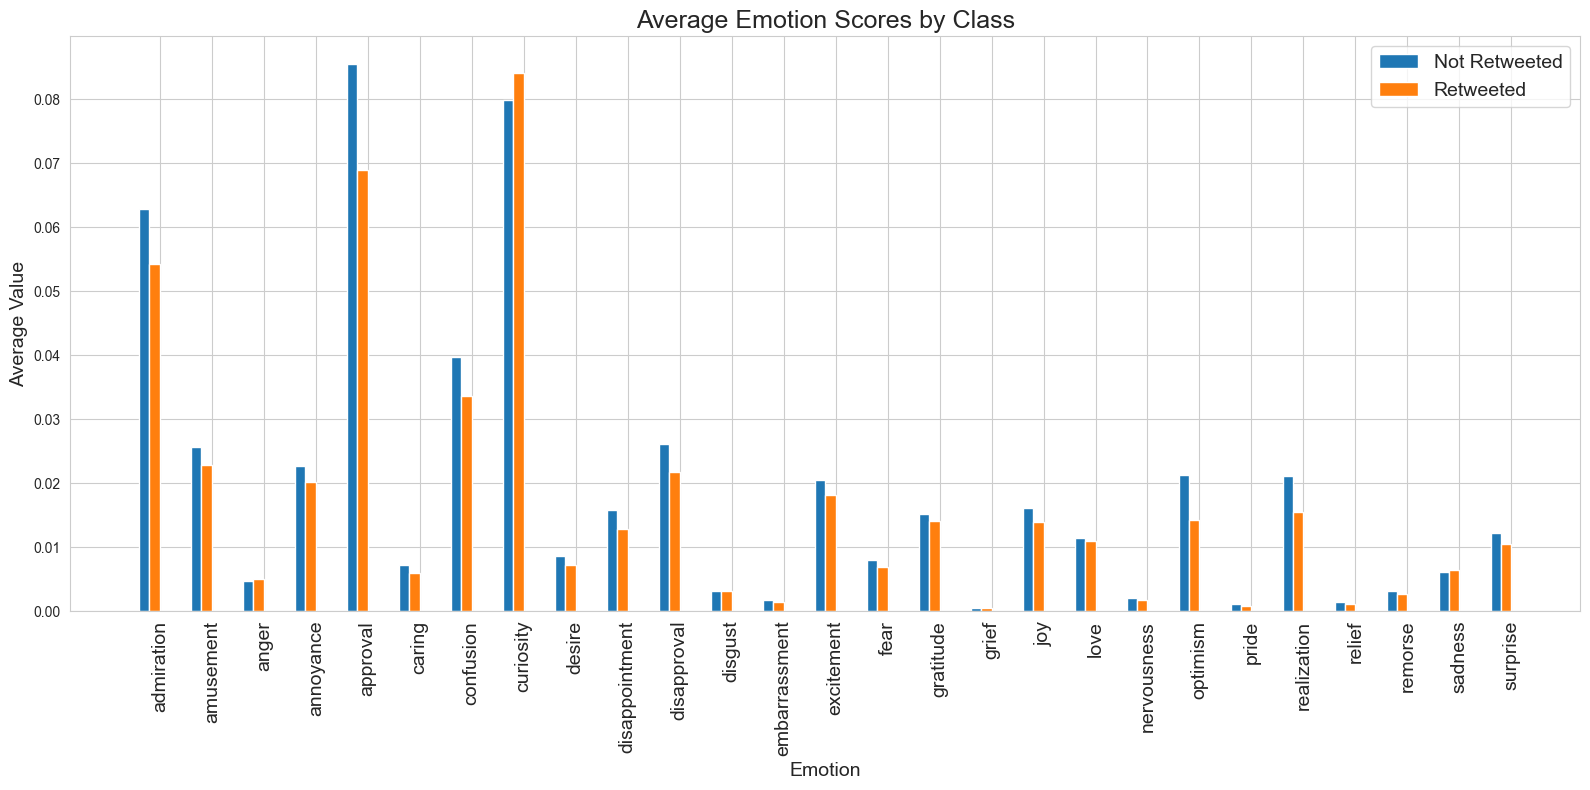

MANOVA Test - Emotions ~ Class
                       Multivariate linear model
                                                                        
------------------------------------------------------------------------
       Intercept         Value    Num DF    Den DF     F Value    Pr > F
------------------------------------------------------------------------
          Wilks' lambda   0.0058 28.0000 321032.0000 1968305.2660 0.0000
         Pillai's trace   0.9942 28.0000 321032.0000 1968305.2660 0.0000
 Hotelling-Lawley trace 171.6731 28.0000 321032.0000 1968305.2660 0.0000
    Roy's greatest root 171.6731 28.0000 321032.0000 1968305.2660 0.0000
------------------------------------------------------------------------
                                                                        
-------------------------------------------------------------------------
            label           Value    Num DF     Den DF    F Value  Pr > F
------------------------------------------

In [10]:
# Emotions ~ label

bar_plot(emotion_by_label, "label", "Average Emotion Scores by Class", "Emotion", "Average Value", "EmotionByClass", 90)

# MANOVA
print("MANOVA Test - Emotions ~ Class")
print(MANOVA.from_formula('admiration + amusement + anger + annoyance + approval + caring + confusion + curiosity + desire + disappointment + disapproval + disgust + embarrassment + excitement + fear + gratitude + grief + joy + love + nervousness + neutral + optimism + pride + realization + relief + remorse + sadness + surprise ~ label', data=tweets).mv_test())

# Independent t-tests
print("Independent t-tests - Emotions ~ Class")
print(f"{'Feature':<{20}} {'t-statistic':<{15}} {'p-value':<{15}} Significance")
for column in emotions.columns:   # Loop through each topic  and perform a t-test
    class_0 = tweets[tweets['label'] == 0][column]
    class_1 = tweets[tweets['label'] == 1][column]
    t_stat, p_value = ttest_ind(class_0, class_1)
    stars = significance_stars(p_value)

    print(f"{column:<{20}} {t_stat:<{15}.4f} {p_value:<{15}.4f} {stars}")

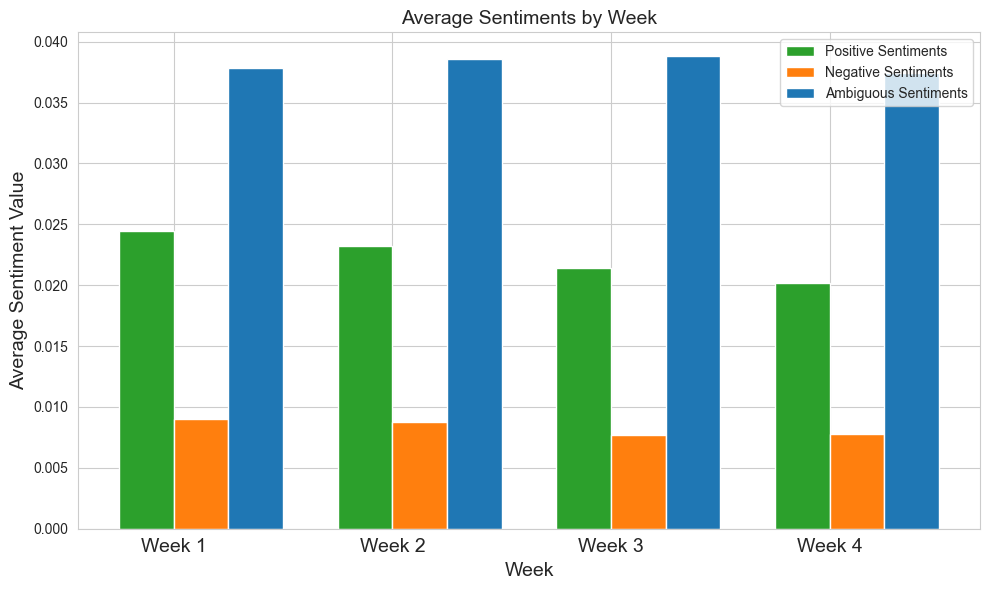

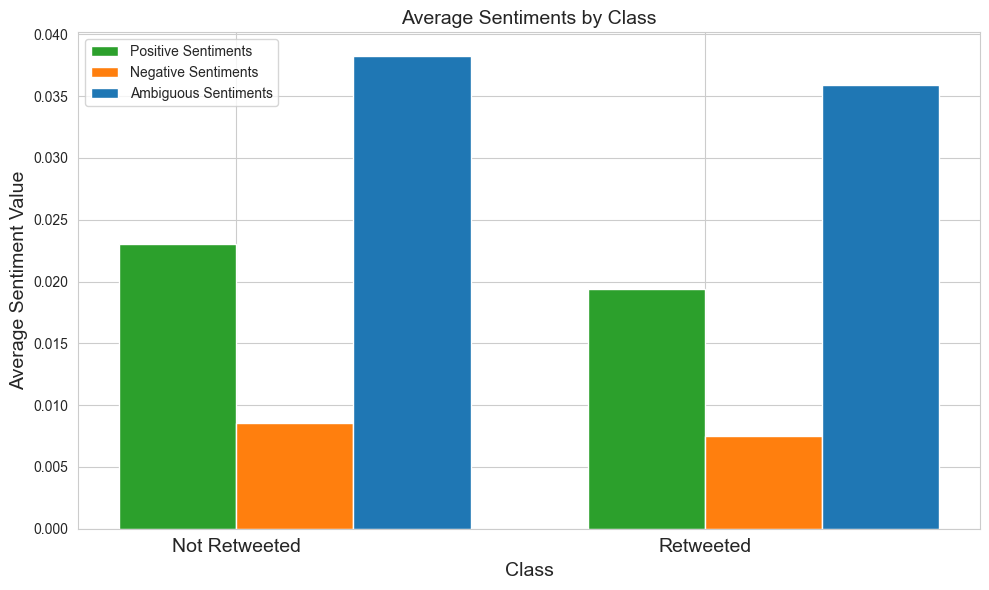

MANOVA Test - Sentiments ~ Label
                     Multivariate linear model
                                                                    
--------------------------------------------------------------------
       Intercept        Value  Num DF    Den DF     F Value   Pr > F
--------------------------------------------------------------------
          Wilks' lambda 0.3995 3.0000 321057.0000 160850.6404 0.0000
         Pillai's trace 0.6005 3.0000 321057.0000 160850.6404 0.0000
 Hotelling-Lawley trace 1.5030 3.0000 321057.0000 160850.6404 0.0000
    Roy's greatest root 1.5030 3.0000 321057.0000 160850.6404 0.0000
--------------------------------------------------------------------
                                                                    
--------------------------------------------------------------------
            label          Value  Num DF    Den DF   F Value  Pr > F
--------------------------------------------------------------------
             Wilks' lam

In [11]:
sentiments_by_week = emotion_by_week.copy()
sentiments_by_label = emotion_by_label.copy()

# Calculate the overall average for positive and negative emotions for each group
sentiments_by_week['positive_avg'] = sentiments_by_week[positive_emotions].mean(axis=1)
sentiments_by_week['negative_avg'] = sentiments_by_week[negative_emotions].mean(axis=1)
sentiments_by_week['ambiguous_avg'] = sentiments_by_week[ambiguous_emotions].mean(axis=1)

sentiments_by_label['positive_avg'] = sentiments_by_label[positive_emotions].mean(axis=1)
sentiments_by_label['negative_avg'] = sentiments_by_label[negative_emotions].mean(axis=1)
sentiments_by_label['ambiguous_avg'] = sentiments_by_label[ambiguous_emotions].mean(axis=1)


positive_values_week = sentiments_by_week['positive_avg']
negative_values_week = sentiments_by_week['negative_avg']
ambiguous_values_week = sentiments_by_week['ambiguous_avg']

positive_values_label = sentiments_by_label['positive_avg']
negative_values_label = sentiments_by_label['negative_avg']
ambiguous_values_label = sentiments_by_label['ambiguous_avg']

bar_width = 0.25
plt.figure(figsize=(10, 6))

# Plot sentiments by week
categories = ['Week 1', 'Week 2', 'Week 3', 'Week 4']
x = range(len(categories))
plt.bar(x, positive_values_week, width=bar_width, label='Positive Sentiments',color='C2')
plt.bar([p + bar_width for p in x], negative_values_week, width=bar_width, label='Negative Sentiments',color='C1')
plt.bar([p + 2*bar_width for p in x], ambiguous_values_week, width=bar_width, label='Ambiguous Sentiments',color='C0')

plt.xlabel('Week', size=14)
plt.ylabel('Average Sentiment Value', size=14)
plt.title('Average Sentiments by Week', size=14)
plt.xticks([p + bar_width/2 for p in x], categories, size=14)
plt.legend()
plt.tight_layout()
plt.savefig("SentimentByWeek", dpi=300)
plt.show()

# Plot sentiments by class
categories = ['Not Retweeted', 'Retweeted']
x = range(len(categories))
plt.figure(figsize=(10, 6))
plt.bar(x, positive_values_label, width=bar_width, label='Positive Sentiments',color='C2')
plt.bar([p + bar_width for p in x], negative_values_label, width=bar_width, label='Negative Sentiments',color='C1')
plt.bar([p + 2*bar_width for p in x], ambiguous_values_label, width=bar_width, label='Ambiguous Sentiments',color='C0')

plt.xlabel('Class', size=14)
plt.ylabel('Average Sentiment Value', size=14)
plt.title('Average Sentiments by Class', size=14)
plt.xticks([p + bar_width/2 for p in x], categories, size=14)
plt.legend()
plt.tight_layout()
plt.savefig("SentimentByClass", dpi=300)
plt.show()

# Sentiment ~ label
tweets['positive_avg'] = tweets[positive_emotions].mean(axis=1)
tweets['negative_avg'] = tweets[negative_emotions].mean(axis=1)
tweets['ambiguous_avg'] = tweets[ambiguous_emotions].mean(axis=1)
cols_to_keep = ['positive_avg', 'negative_avg', 'ambiguous_avg']
sentiments = tweets.loc[:, cols_to_keep]
# MANOVA
print("MANOVA Test - Sentiments ~ Label")
print(MANOVA.from_formula('positive_avg + negative_avg + ambiguous_avg ~ label', data=tweets).mv_test())

# Independent t-tests
print("Independent t-tests - Topics ~ Class")
print(f"{'Feature':<{20}} {'t-statistic':<{15}} {'p-value':<{15}} Significance")
for column in sentiments.columns:   # Loop through each topic  and perform a t-test
    class_0 = tweets[tweets['label'] == 0][column]
    class_1 = tweets[tweets['label'] == 1][column]
    t_stat, p_value = ttest_ind(class_0, class_1)
    stars = significance_stars(p_value)
    print(f"{column:<{20}} {t_stat:<{15}.4f} {p_value:<{15}.4f} {stars}")
    

# Sentiment ~ label
tweets['positive_avg'] = tweets[positive_emotions].mean(axis=1)
tweets['negative_avg'] = tweets[negative_emotions].mean(axis=1)
tweets['ambiguous_avg'] = tweets[ambiguous_emotions].mean(axis=1)
cols_to_keep = ['positive_avg', 'negative_avg', 'ambiguous_avg']
sentiments = tweets.loc[:, cols_to_keep]
# MANOVA
print("MANOVA Test - Sentiments ~ Label")
print(MANOVA.from_formula('positive_avg + negative_avg + ambiguous_avg ~ label', data=tweets).mv_test())

# Independent t-tests
print("Independent t-tests - Topics ~ Class")
print(f"{'Feature':<{20}} {'t-statistic':<{15}} {'p-value':<{15}} Significance")
for column in sentiments.columns:   # Loop through each topic  and perform a t-test
    class_0 = tweets[tweets['label'] == 0][column]
    class_1 = tweets[tweets['label'] == 1][column]
    t_stat, p_value = ttest_ind(class_0, class_1)
    stars = significance_stars(p_value)
    print(f"{column:<{20}} {t_stat:<{15}.4f} {p_value:<{15}.4f} {stars}")

In [15]:
# Topics
df_topics = tweets.drop(columns=["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment",  "excitement",  "fear", "gratitude", "grief", "joy", "love", "nervousness", "neutral", "optimism", "pride", "realization", "relief", "remorse", "sadness",  "surprise", 'positive_avg', 'negative_avg', 'ambiguous_avg'])


topics_by_week= df_topics.groupby("week").sum().reset_index()
topics_by_week.columns = topics_by_week.columns.str.replace(r"^t\.", "", regex=True)
pd.set_option('display.max_columns', None)
topics_by_week = topics_by_week.drop("label", axis=1)
print(topics_by_week)

topics_by_label= df_topics.groupby("label").sum().reset_index()
topics_by_label.columns = topics_by_label.columns.str.replace(r"^t\.", "", regex=True)
pd.set_option('display.max_columns', None)
topics_by_label = topics_by_label.drop("week", axis=1)
print(topics_by_label)


   week  topic_1  topic_2  topic_3  topic_4  topic_5  topic_6  topic_7  \
0     1    63922     5974    11107     3529     5038    14334     9587   
1     2    42861     3863     7365     2283     4089    10487     5212   
2     3    27079     3472     4645     1642     3060     7197     3407   
3     4    24851     3504     3452     1386     2867     5984     2824   

   topic_8  topic_9  
0     5874     8142  
1     3852     5713  
2     2484     4094  
3     2029     3852  
   label  topic_1  topic_2  topic_3  topic_4  topic_5  topic_6  topic_7  \
0      0   150845    16107    25074     8601    14592    36166    20274   
1      1     7868      706     1495      239      462     1836      756   

   topic_8  topic_9  
0    13635    20758  
1      604     1043  


   week   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
0     1  0.501321  0.046852  0.087109  0.027677  0.039512  0.112417  0.075188   
1     2  0.499983  0.045063  0.085914  0.026632  0.047699  0.122333  0.060799   
2     3  0.474404  0.060827  0.081377  0.028767  0.053609  0.126086  0.059688   
3     4  0.489685  0.069046  0.068021  0.027311  0.056494  0.117914  0.055646   

    topic_8   topic_9  
0  0.046068  0.063855  
1  0.044934  0.066643  
2  0.043518  0.071724  
3  0.039981  0.075903  


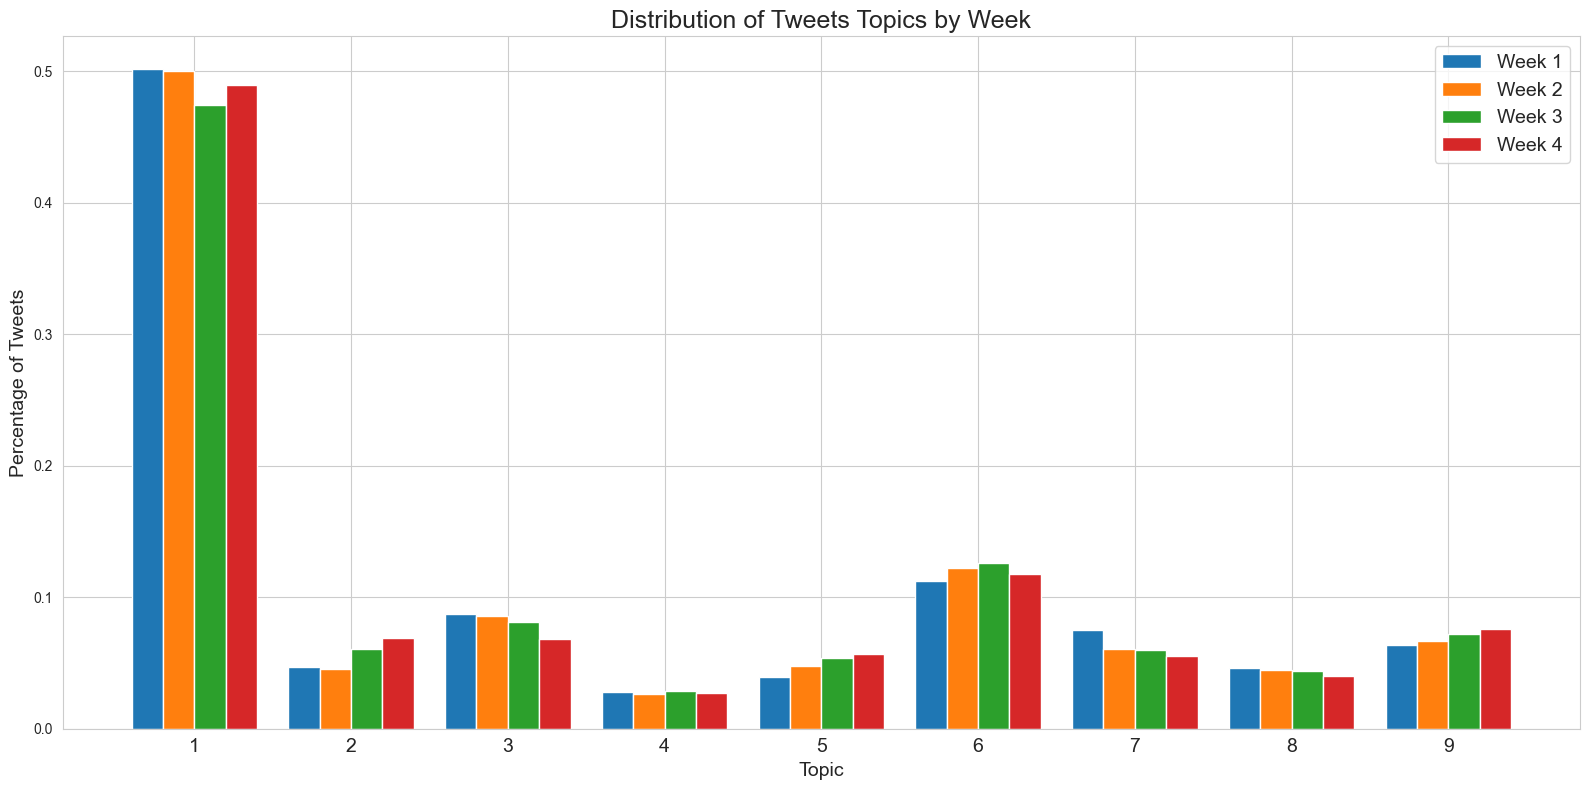

MANOVA Test - Topics ~ Week
                                Multivariate linear model
                                                                                         
-----------------------------------------------------------------------------------------
       Intercept              Value       Num DF    Den DF          F Value        Pr > F
-----------------------------------------------------------------------------------------
          Wilks' lambda            0.0000 9.0000 321051.0000 4453454208187317.5000 0.0000
         Pillai's trace            1.0000 9.0000 321051.0000 4453454208187318.0000 0.0000
 Hotelling-Lawley trace 124843367171.2153 9.0000 321051.0000 4453454208187317.0000 0.0000
    Roy's greatest root 124843367171.2153 9.0000 321051.0000 4453454208187317.5000 0.0000
-----------------------------------------------------------------------------------------
                                                                                         
--------------

In [16]:
# Topics ~ week

# Calculate total tweets per week
total_tweets_per_week = topics_by_week.groupby('week').sum().sum(axis=1)
# Calculate percentages
topics_by_week_perc = topics_by_week.set_index('week').div(total_tweets_per_week, axis=0).reset_index()
print(topics_by_week_perc)
bar_plot(topics_by_week_perc, "week", "Distribution of Tweets Topics by Week", "Topic", "Percentage of Tweets", "TopicByWeek", 0 )

# MANOVA
print("MANOVA Test - Topics ~ Week")
print(MANOVA.from_formula('topic_1 + topic_2 + topic_3 + topic_4 + topic_5 + topic_6 + topic_7 + topic_8 + topic_9 ~ week', data=tweets).mv_test())

# One-way ANOVA
print("One-way ANOVA - Topics ~ Week")
print(f"{'Feature':<{20}} {'F-statistic':<{15}} {'p-value':<{15}} Significance")
for column in topics.columns:   # Loop through each emotion feature and perform a one-way ANOVA
    week_1 = tweets[tweets['week'] == 1][column]
    week_2 = tweets[tweets['week'] == 2][column]
    week_3 = tweets[tweets['week'] == 3][column]
    week_4 = tweets[tweets['week'] == 4][column]
    
    # Perform one-way ANOVA
    f_stat, p_value = f_oneway(week_1, week_2, week_3, week_4)
    stars = significance_stars(p_value)

    print(f"{column:<{20}} {f_stat:<{15}.4f} {p_value:<{15}.4f} {stars}")

   label   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
0      0  0.492874  0.052628  0.081927  0.028103  0.047678  0.118169   
1      1  0.524219  0.047038  0.099607  0.015924  0.030782  0.122327   

    topic_7   topic_8   topic_9  
0  0.066244  0.044551  0.067825  
1  0.050370  0.040243  0.069492  


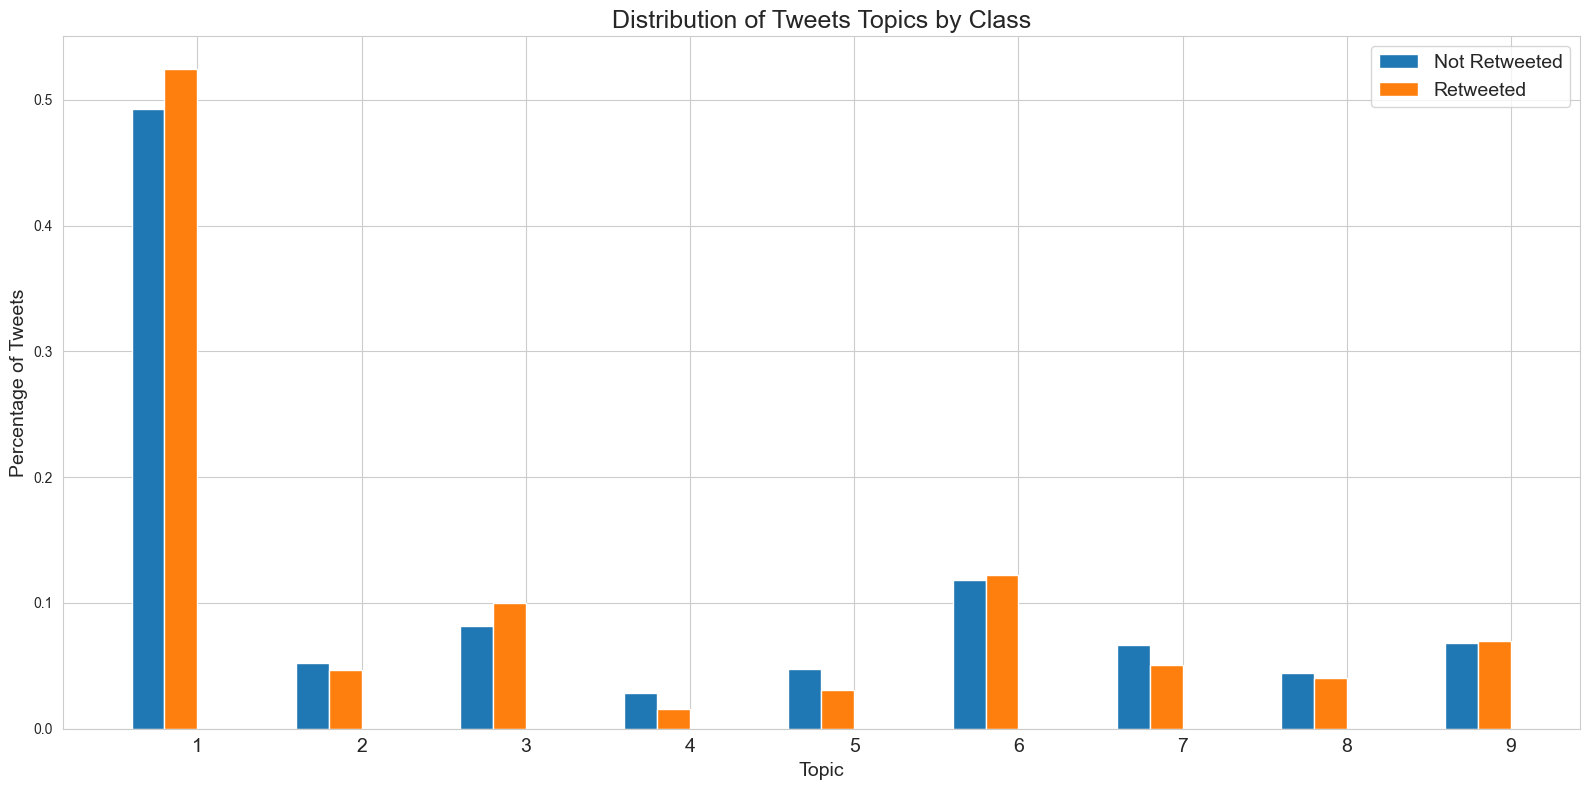

       topic_1  topic_2  topic_3  topic_4  topic_5  topic_6  topic_7  topic_8  \
label                                                                           
0       150845    16107    25074     8601    14592    36166    20274    13635   
1         7868      706     1495      239      462     1836      756      604   

       topic_9  
label           
0        20758  
1         1043  
         topic_1    topic_2    topic_3   topic_4    topic_5    topic_6  \
label                                                                    
0      95.042624  95.800868  94.373142  97.29638  96.931048  95.168675   
1       4.957376   4.199132   5.626858   2.70362   3.068952   4.831325   

         topic_7    topic_8    topic_9  
label                                   
0      96.405136  95.758129  95.215816  
1       3.594864   4.241871   4.784184  


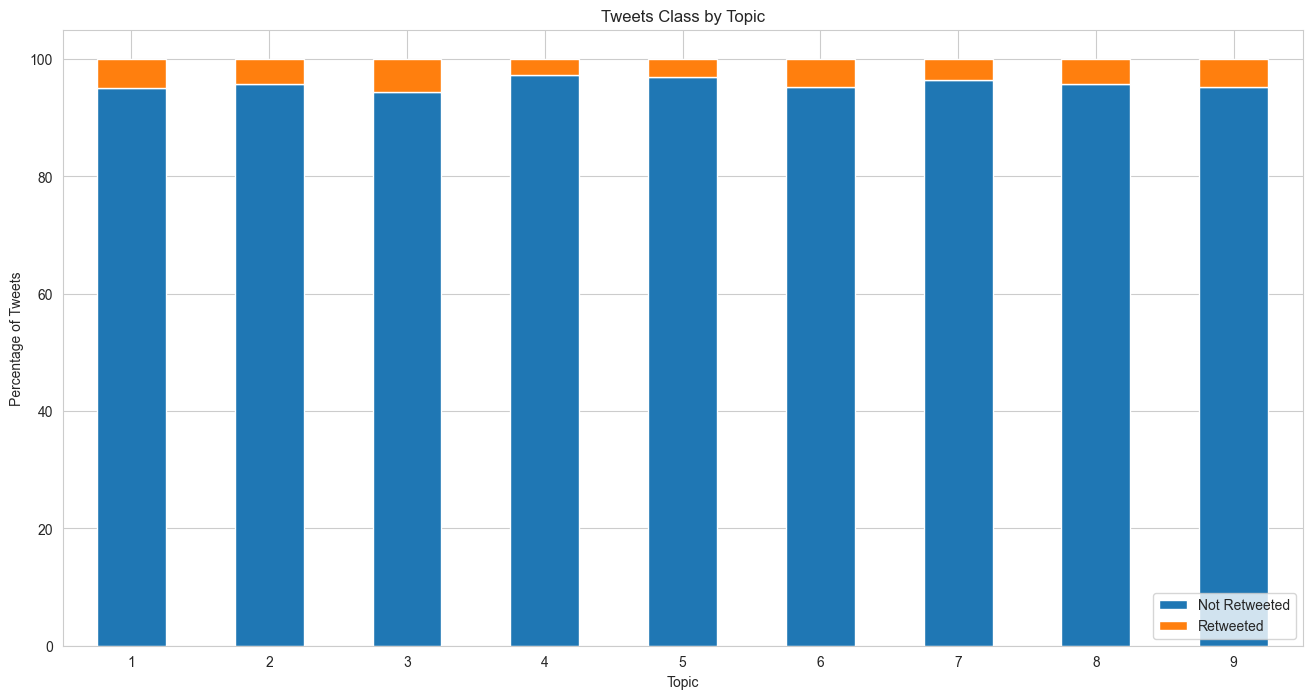

MANOVA Test - Topics ~ Label
                                  Multivariate linear model
                                                                                             
---------------------------------------------------------------------------------------------
       Intercept               Value        Num DF    Den DF           F Value         Pr > F
---------------------------------------------------------------------------------------------
          Wilks' lambda             -0.0000 9.0000 321051.0000 -52160359450501944.0000 1.0000
         Pillai's trace              1.0000 9.0000 321051.0000 -52160359450501952.0000 1.0000
 Hotelling-Lawley trace -1462207671225.1870 9.0000 321051.0000 -52160359450501944.0000 1.0000
    Roy's greatest root -1462207671225.1870 9.0000 321051.0000 -52160359450501952.0000 1.0000
---------------------------------------------------------------------------------------------
                                                                 

In [20]:
# Topics ~ label

# Calculate total tweets per label
total_tweets_per_label = topics_by_label.groupby('label').sum().sum(axis=1)
# Calculate percentages
topics_by_label_perc = topics_by_label.set_index('label').div(total_tweets_per_label, axis=0).reset_index()
print(topics_by_label_perc)
bar_plot(topics_by_label_perc, "label", "Distribution of Tweets Topics by Class", "Topic", "Percentage of Tweets", "TopicByLabel2", 0 )

df_topics1 = df_topics.drop(["week"], axis=1)
legend_labels = ["Not Retweeted", "Retweeted"]

# Convert True/False to integer counts
df_counts = df_topics1.groupby('label').sum()

# Calculate percentages
df_percentages = df_counts.div(df_counts.sum(axis=0), axis=1) * 100
print(df_counts)
print(df_percentages)

# Transpose and prepare for plotting
df_percentages_transposed = df_percentages.T
df_percentages_transposed.columns = [f'Class {col}' for col in df_percentages_transposed.columns]

# Plotting
ax = df_percentages_transposed.plot(kind='bar', stacked=True, figsize=(16, 8))
ax.set_xlabel('Topic')
ax.set_ylabel('Percentage of Tweets')
ax.set_title("Tweets Class by Topic")
plt.legend(labels=legend_labels, loc='lower right')
ax.set_xticklabels(range(1, len(df_percentages_transposed) + 1), rotation=0)
plt.savefig('TweetsClassDistributionByTopic.png', dpi=300) 
plt.show()


# MANOVA
print("MANOVA Test - Topics ~ Label")
print(MANOVA.from_formula('topic_1 + topic_2 + topic_3 + topic_4 + topic_5 + topic_6 + topic_7 + topic_8 + topic_9 ~ label', data=tweets).mv_test())

# Independent t-tests
print("Independent t-tests - Topics ~ Class")
print(f"{'Feature':<{20}} {'t-statistic':<{15}} {'p-value':<{15}} Significance")
for column in topics.columns:   # Loop through each topic and perform a t-test
    class_0 = tweets[tweets['label'] == 0][column]
    class_1 = tweets[tweets['label'] == 1][column]
    t_stat, p_value = ttest_ind(class_0, class_1)
    stars = significance_stars(p_value)
    print(f"{column:<{20}} {t_stat:<{15}.4f} {p_value:<{15}.4f} {stars}")